# Predicting the survival on the Titanic using Machine Learning

## Objective:
- The input dataset (train.csv) provides information on the Titanic passengers; these will be used as inputs in order to predict the survival using ML models.
- The input variables (predictors) are: Passenger ID, Passenger class, Name, Sex, Age, SibSp (# of siblings + spouse), Parch (# of parents + children), Ticket #, Fare, Cabin #, and Port of Embarkation. 
- The response or dependent variable is: Survived
- We would like to use Machine Learning to find out how likely a passenger would survive based on their class, age, sex, ...

### Importing required libraries:

In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sb
import os

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier,RadiusNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb

### Reading the input file and previewing the data:

In [3]:
train_file = '/kaggle/input/titanic/train.csv'
train_df = pd.read_csv(train_file)
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now, we have a better understanding of variables:

predictors:
Numerical continuous variables: PassengerId, Age, SibSp, Parch, Fare
Categorical, ordinal, or binary variables: Embarked, Pclass, Sex
String variables: Cabin, Ticket, Name

dependent variable:
Survived: binary variable


## Data Cleaing:

### Step 1: Taking care of wrong values or outliers:

In [4]:
train_df.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Vande Velde, Mr. Johannes Joseph",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Basic statistics show there is no obviously wrong values (such as negative values or a person of 300 year-old).

### Step 2: Taking care of missing values:

In [5]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- Cabin is missed for the the majority of data points. Also, this variable is very unlikely to affect the survival. We will drop this variable later.

- Embarked has only 2 missing values. Since this is a categorical variable, we use mode to impute missing values:

In [6]:
Embarked_mode = train_df.Embarked.mode()[0]
#train_df.Embarked[train_df.Embarked.isna()] = Embarked_mode
train_df.Embarked.fillna(Embarked_mode, inplace = True)

- Age has 177 missing values. Since this is a numerical variable, the easiest way is using mean or median to impute missing values. The more complex way would grouping by another variable (e.g. Sex, Pclass, or Parch) and using mean age in each group for filling missing values. We impute the missing values using median:

In [7]:
Age_median = train_df.Age.median()
train_df.Age.fillna(Age_median, inplace = True)

Let's double-check the process of imputing the missing values:

In [8]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

### Step 3: Dropping irrelevant variables:
- We drop PassengerId, Name, Ticket, and Cabin because there is no logical relationship between survival and each of those variables, and any apparent association should be noise.

In [9]:
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Step 4: Converting categorical variables to dummy variables:
- Categorical variables are Sex and Embarked.
- First, we change Sex from male/female to 1/0, and change Embarked from S/C/Q to 0/1/2:

In [10]:
from sklearn.preprocessing import LabelEncoder
Sex_encode = LabelEncoder().fit_transform(train_df.Sex)
Embarked_encode = LabelEncoder().fit_transform(train_df.Embarked)

print(Sex_encode[:10], Embarked_encode[:10])

[1 0 0 0 1 1 1 1 0 0] [2 0 2 2 2 1 2 2 2 0]


Since Embarked variable is not ordinar, we need to convert it to binary:

In [11]:
from sklearn.preprocessing import OneHotEncoder

Embarked_1hot = OneHotEncoder().fit_transform(Embarked_encode.reshape(-1, 1))
Embarked_1hot = Embarked_1hot.toarray()

print(Embarked_1hot[:5])

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


Now, we drop categorical Sex and Embarked from DataFrame and add the encoded Sex and Embarked:

In [12]:
train_df.drop(['Sex', 'Embarked'], inplace = True, axis=1)

In [66]:
Sex_df      = pd.DataFrame(Sex_encode, columns = ['Sex_encded'])
Embarked_df = pd.DataFrame(Embarked_1hot, columns = ['Embrk_C', 'Embrk_Q', 'Embrk_S'])
train_cl_df = pd.concat([train_df, Sex_df, Embarked_df], axis=1)

print(train_cl_df.describe())
print()
print(train_cl_df.head())
print()
train_cl_df.isna().sum()

         Survived      Pclass         Age       SibSp       Parch        Fare  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642   29.361582    0.523008    0.381594   32.204208   
std      0.486592    0.836071   13.019697    1.102743    0.806057   49.693429   
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000   
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.910400   
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200   
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000   
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200   

       Sex_encded     Embrk_C     Embrk_Q     Embrk_S  
count  418.000000  418.000000  418.000000  418.000000  
mean     0.636364    0.244019    0.110048    0.645933  
std      0.481622    0.430019    0.313324    0.478803  
min      0.000000    0.000000    0.000000    0

Survived        0
Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
Sex_encded    473
Embrk_C       473
Embrk_Q       473
Embrk_S       473
dtype: int64

### Step 5: feature engineering:

Apart from the current variables, can we think of other factors that affected the survival?

Think of people who were lonely. It is most likely that they had a better chance of survival, because they were probabely woried just about their own survival. 

Let's check this by creating a new variable for loneliness:

In [67]:
family_members = train_df.Parch + train_df.SibSp
lonely = family_members + 1
lonely[family_members == 0] = 1
lonely[family_members > 0] = 0
lonely.describe()

count    891.000000
mean       0.602694
std        0.489615
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64

In [68]:
Lonely_df   = pd.DataFrame(lonely, columns = ['Lonely'])
train_cl_df = pd.concat([train_cl_df, Lonely_df], axis=1)
train_cl_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_encded,Embrk_C,Embrk_Q,Embrk_S,Lonely
0,0,3,22.0,1,0,7.2500,1.0,0.0,1.0,0.0,0
1,1,1,38.0,1,0,71.2833,0.0,0.0,0.0,1.0,0
2,1,3,26.0,0,0,7.9250,1.0,0.0,1.0,0.0,1
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,1.0,0
4,0,3,35.0,0,0,8.0500,0.0,0.0,0.0,1.0,1


## Finding meaning in data:
What possible relationships exist between variables?

Using pairplot to find the relationship between each pair of variables:

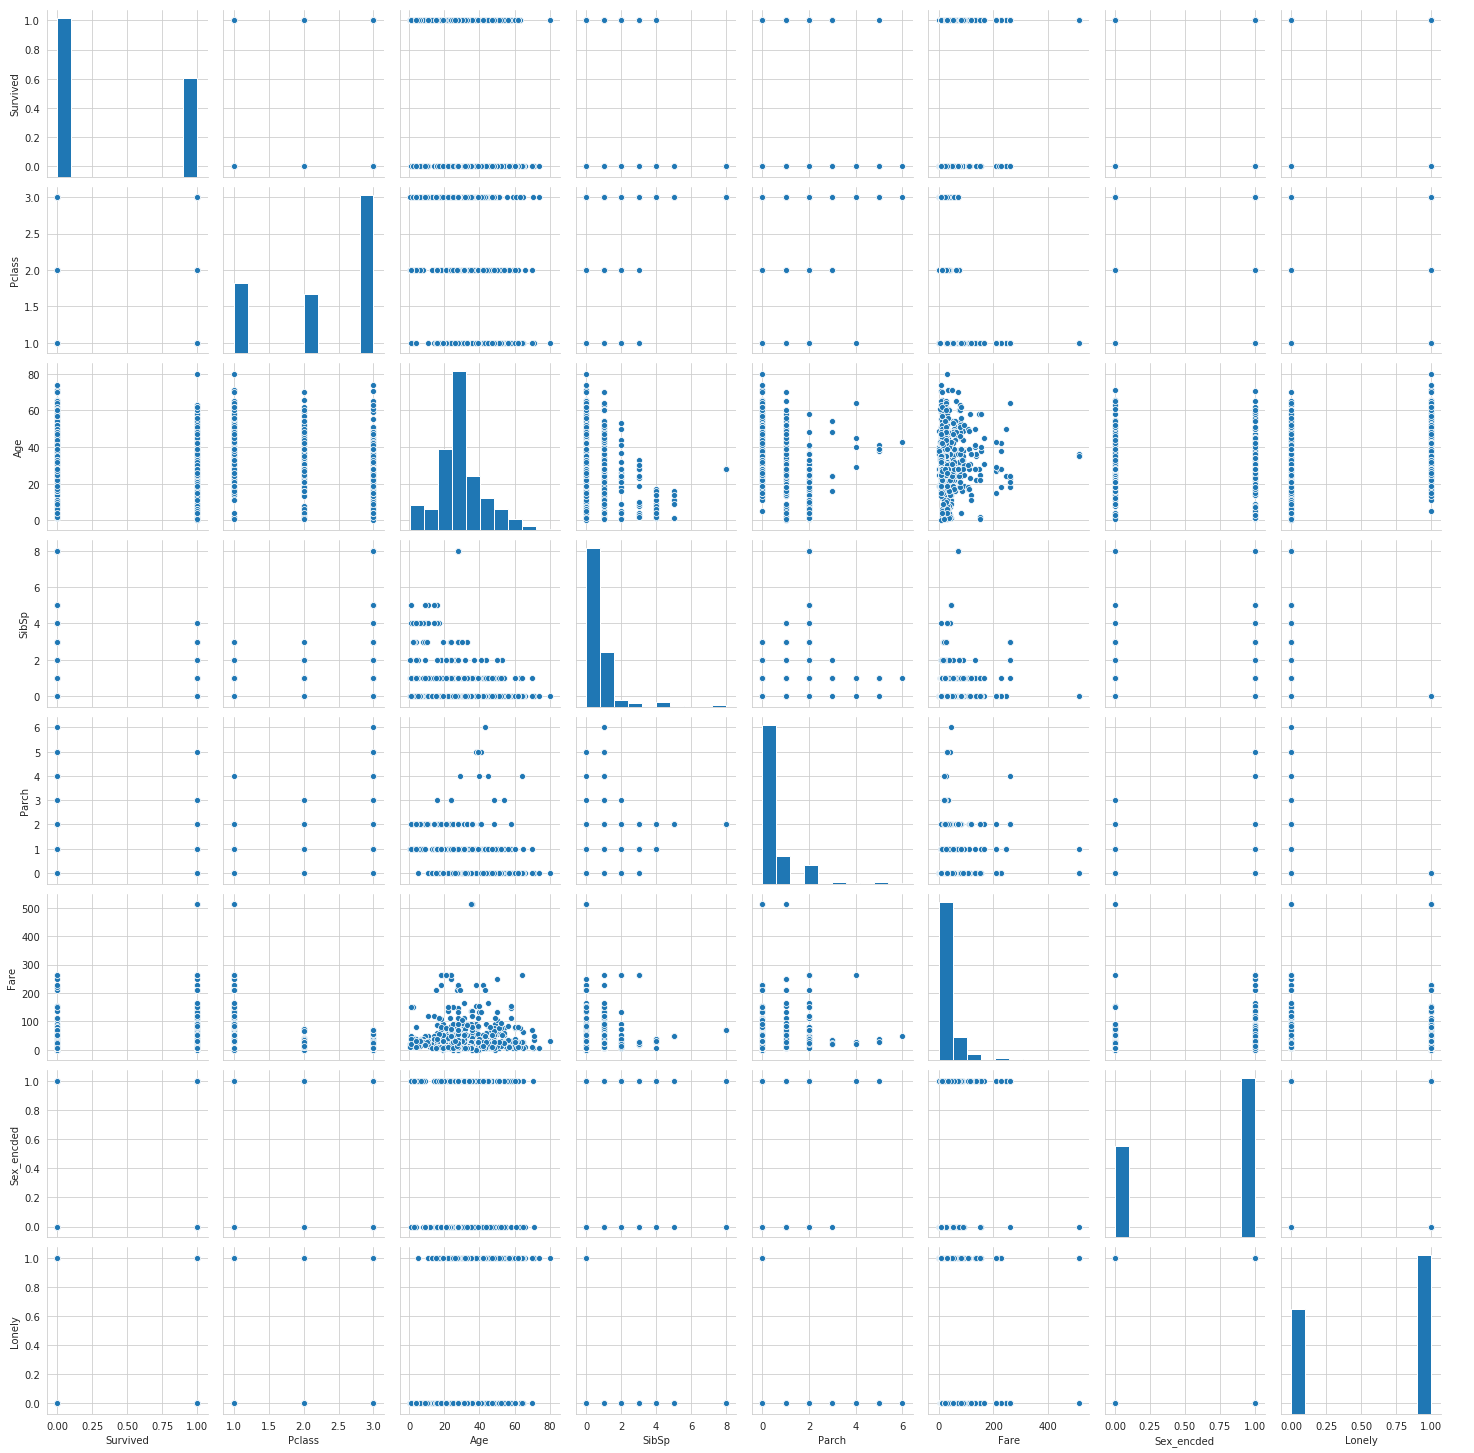

In [69]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

sb.pairplot(train_cl_df, vars = ['Survived','Pclass','Age','SibSp','Parch','Fare','Sex_encded','Lonely'], palette = 'husl')
plt.show()

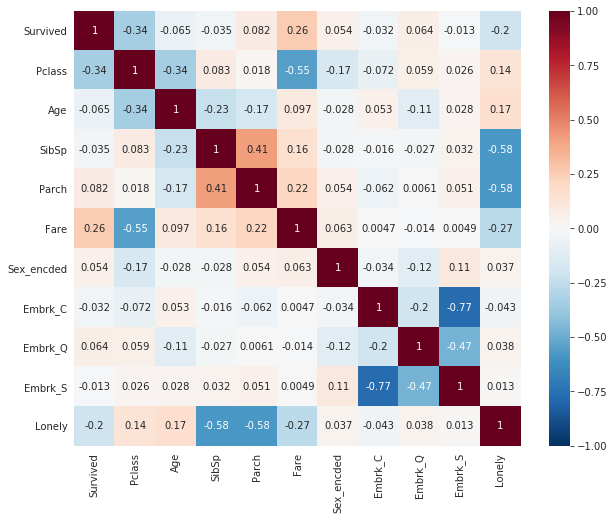

In [70]:
# Using heatmap to see the correlation between each pair of variables:

sb.heatmap(train_cl_df.corr(), vmin=-1, vmax=1, annot=True, cmap = "RdBu_r")# , center=0, cmap = "coolwarm")
plt.show()

Let's take a look at variables that have the highest correlation with Survived.
- Females had a significantly higher chance of survival.
- First class passenger were more likely to survive. Compared to third class, second class passenger were more likely to survive.
- Lonely people had a less chance of survival.
- People who embarked from France were more likely to survive than those embarked from Ireland.

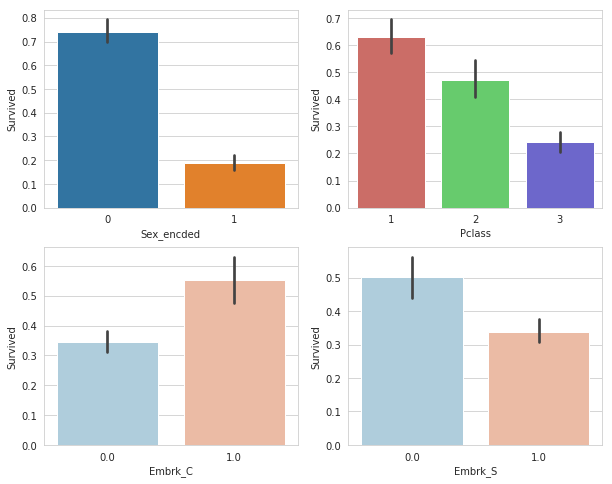

In [62]:
fig, axis = plt.subplots(2, 2,figsize=(10,8))
sb.barplot(x = 'Sex_encded', y ='Survived', data = train_cl_df, ax = axis[0,0])
sb.barplot(x = 'Pclass',     y ='Survived', data = train_cl_df, ax = axis[0,1], palette = 'hls')
sb.barplot(x = 'Embrk_C',    y ='Survived', data = train_cl_df, ax = axis[1,0], palette = 'RdBu_r')
sb.barplot(x = 'Embrk_S',    y ='Survived', data = train_cl_df, ax = axis[1,1], palette = 'RdBu_r')
plt.show()

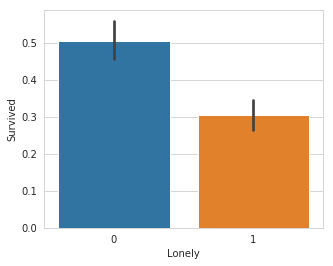

In [61]:
rcParams['figure.figsize'] = 5, 4
sb.barplot(x = 'Lonely', y ='Survived', data = train_cl_df)
plt.show()

### Checking if predictors are independent of each other:

We should also be careful if there is a high correlation between two predictors.

- Fare and Pclass are highly correlated: First class passengers paid much more: the more they paid the higher their chance of survival.

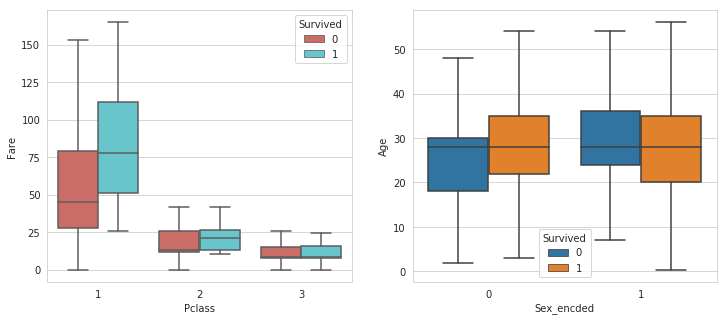

In [20]:
fig, axis = plt.subplots(1, 2,figsize=(12,5))
sb.boxplot(x = 'Pclass', y ='Fare', data = train_cl_df, hue = 'Survived', showfliers = False, ax = axis[0], palette = 'hls')
sb.boxplot(x = 'Sex_encded', y ='Age', data = train_cl_df, hue = 'Survived', showfliers = False, ax = axis[1])
plt.show()

A few more graphs before we decide which variables we keep for the machine learning modeling:

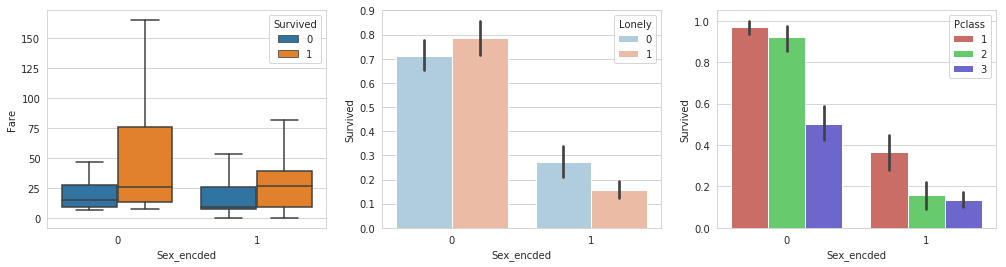

In [21]:
fig, axis = plt.subplots(1, 3,figsize=(17,4))
sb.boxplot(x = 'Sex_encded', y ='Fare', data = train_cl_df, ax = axis[0], hue = 'Survived', showfliers = False)
sb.barplot(x = 'Sex_encded', y ='Survived', data = train_cl_df, ax = axis[1], hue = 'Lonely', palette = 'RdBu_r')
sb.barplot(x = 'Sex_encded', y ='Survived', data = train_cl_df, ax = axis[2], hue = 'Pclass', palette = 'hls')
plt.show()

We should only keep predictors that are indepenent. If two predictors are highly correlated, we drop one of them:

- Dropping Fare (Pclass has higher correlation with Survived).

In [22]:
train_cl_df.drop(['Fare'], inplace = True, axis=1)
train_cl_df.head()

,Survived,Pclass,Age,SibSp,Parch,Sex_encded,Embrk_C,Embrk_Q,Embrk_S,Lonely
0,0,3,22.0,1,0,1,0.0,0.0,1.0,0
1,1,1,38.0,1,0,0,1.0,0.0,0.0,0
2,1,3,26.0,0,0,0,0.0,0.0,1.0,1
3,1,1,35.0,1,0,0,0.0,0.0,1.0,0
4,0,3,35.0,0,0,1,0.0,0.0,1.0,1


### - Checking if the dataset size is sufficient
### - Checking if everything looks good

In [23]:
print(train_cl_df.info())
train_cl_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Sex_encded    891 non-null int64
Embrk_C       891 non-null float64
Embrk_Q       891 non-null float64
Embrk_S       891 non-null float64
Lonely        891 non-null int64
dtypes: float64(4), int64(6)
memory usage: 69.7 KB
None


,Survived,Pclass,Age,SibSp,Parch,Sex_encded,Embrk_C,Embrk_Q,Embrk_S,Lonely
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,0.647587,0.188552,0.086420,0.725028,0.602694
std,0.486592,0.836071,13.019697,1.102743,0.806057,0.477990,0.391372,0.281141,0.446751,0.489615
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,3.000000,35.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Implementing Machine Learning Algorithms:


## Spliting the data into test and train sets:

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(train_cl_df.drop('Survived', axis=1),
                                                   train_cl_df['Survived'], test_size=0.2, random_state=10)                             


## Machine learning models:

- Based on the nature of the problem (categorical outcome) and the size of data (small), we can expect that Logistic Regression algorithm would do the job, but if we want to achieve the best result (in this case, highest accuracy, because our purpose is the best prediction), we should test a variety of proper ML models, especially ensemble models. 
- The dataset for this case is not big, otherwise we should also be wary of time and space complexities.

In [58]:
all_classifiers = {'Gradient Boost': GradientBoostingClassifier(),
                 'Ada Boost': AdaBoostClassifier(),
                 'Random Forest': RandomForestClassifier(),
                 'Logistic Regression': LogisticRegression(solver='liblinear',fit_intercept=True),
                 'Decision Tree' : DecisionTreeClassifier(),
                 'KNN': KNeighborsClassifier(),
                 'Gaussian NB': GaussianNB(),
                 'Beroulli  NB': BernoulliNB(),
                  'SVC': SVC(probability = False )}  

In [59]:
ML_name = []
ML_accuracy = []
for Name,classifier in all_classifiers.items():
    classifier.fit(X_train,Y_train)
    Y_pred = classifier.predict(X_test)
    ML_accuracy.append(metrics.accuracy_score(Y_test,Y_pred)) 
    ML_name.append(Name) 

### Initial Evaluation:

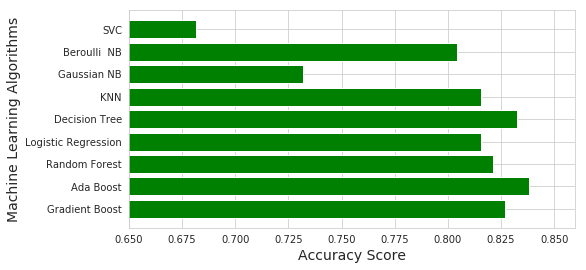

In [60]:
rcParams['figure.figsize'] = 8, 4
plt.barh(ML_name, ML_accuracy, color = 'g')
plt.xlabel('Accuracy Score', fontsize = '14')
plt.ylabel('Machine Learning Algorithms', fontsize = '14')
plt.xlim([0.65, 0.86])
plt.show()

## Tuning models with hyper-parameters:

- Let's see if we can improve a model performance by changing the hyper parameters.
- We are not going to test all the models, but just a few of them.

### Ada Boost Classifier:

In [43]:
n_estim = [30, 50, 100, 200, 500]
learn_r = [1., 2., 3., 5., 10.]

max_score = 0

for n in n_estim:
    for lr in learn_r:
        MLA = AdaBoostClassifier(n_estimators = n, learning_rate = lr)
        MLA.fit(X_train,Y_train)
        Y_pred = MLA.predict(X_test)
        if metrics.accuracy_score(Y_test,Y_pred) > max_score:
            max_score, n_best, r_best = metrics.accuracy_score(Y_test,Y_pred), n, lr

print('maximum accuracy score, n_estimators, learning_rate:')
print(max_score, n_best, r_best)

maximum accuracy score, n_estimators, learning_rate:
0.8379888268156425 30 1.0


### Random Forest:

In [53]:
#n_estimators=100, min_samples_leaf=10, min_samples_split=20, max_depth=6),
n_estim       = [50, 100, 200]
min_samp_lf   = [1, 2, 5, 10]
min_samp_splt = [2, 4, 8, 12]
maxim_depth   = [2, 4, 8, 12, None]

max_score = 0

for n in n_estim:
    for ml in min_samp_lf:
        for ms in min_samp_splt:
            for md in maxim_depth:
                MLA = RandomForestClassifier(n_estimators=n, min_samples_leaf=ml, min_samples_split=ms, max_depth=md)
                MLA.fit(X_train,Y_train)
                Y_pred = MLA.predict(X_test)
                if metrics.accuracy_score(Y_test,Y_pred) > max_score:
                    max_score, n_best, l_best, s_best, d_best = metrics.accuracy_score(Y_test,Y_pred), n, ml, ms, md

print('maximum accuracy score, n_estimators, min_samples_leaf, min_samples_split, max_depth:')
print(max_score, n_best, l_best, s_best, d_best)

maximum accuracy score, n_estimators, min_samples_leaf, min_samples_split, max_depth:
0.8715083798882681 50 2 8 None


### Decision Tree:

In [46]:
criteri       = ['gini', 'entropy']
min_samp_lf   = [1, 2, 5, 10]
min_samp_splt = [2, 4, 8, 12]
maxim_depth   = [2, 4, 8, 12, None]

max_score = 0

for c in criteri:
    for ml in min_samp_lf:
        for ms in min_samp_splt:
            for md in maxim_depth:
                MLA = DecisionTreeClassifier(criterion=c, min_samples_leaf=ml, min_samples_split=ms, max_depth=md)
                MLA.fit(X_train,Y_train)
                Y_pred = MLA.predict(X_test)
                if metrics.accuracy_score(Y_test,Y_pred) > max_score:
                    max_score, c_best, l_best, s_best, d_best = metrics.accuracy_score(Y_test,Y_pred), c, ml, ms, md


print('maximum accuracy score, criterion, min_samples_leaf, min_samples_split, max_depth:')
print(max_score, c_best, l_best, s_best, d_best)

maximum accuracy score, criterion, min_samples_leaf, min_samples_split, max_depth:
0.8659217877094972 gini 1 8 None


- Although tuning the hyper-parameters is not very helpful for Ada Boost algorithm, it does improve the accuracy score for both RF and DT.
- The tuning also shows that a high number of estimators for ensemble algorithms does not necessarily result in high accuracy, but does increase the computation time.

## Further Evaluation for DT:

In [51]:
MLA = DecisionTreeClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=8, max_depth=None)
MLA.fit(X_train,Y_train)
Y_pred = MLA.predict(X_test)
print(metrics.classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       117
           1       0.84      0.76      0.80        62

    accuracy                           0.87       179
   macro avg       0.86      0.84      0.85       179
weighted avg       0.86      0.87      0.86       179



- The classification report shows that the non-survival accuracy score is higher than survival accuracy score by 10%.
- In our test set, the number of non-survival cases is almost twice the number of survival cases.

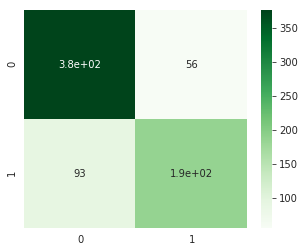

In [52]:
Y_train_pred = cross_val_predict(MLA, X_train, Y_train)
rcParams['figure.figsize'] = 5, 4
sb.heatmap(confusion_matrix(Y_train, Y_train_pred), annot=True, cmap='Greens')
plt.show()

- The result of confusion matrix is good when the values on the upper left and lower right are high and other values are low, which is the case here.
- It shows that the cases of false predictions for non-survival (56) and survival (93) are much lower than cases of true predictions for non-survival (380) and survival (190).
- This verifies that there is no systematic error that our MLA always predicts non-survival when it is in fact survival.

## Discussion:

- With the specific hyper parameters, both RF and DT algorithms provided good values of accuracy score (RF provided the best). Note that it gets very difficult to increase the accuracy score higher than a certain value.

- The results of our MLAs are much better than the baseline: we should be able to predict survival by 50% accuracy only by tossing a coin. Moreover, 62% of passengers did not survive. So, if we always select not survived, we would get a score of 62%. This means that our MLAs improved the accuracy score by 25%.

- Now that we get the highest accuracy from hyper-parameter tuning and from feature engineering, it's time to prepare the external evaluation file.

## Preparing data file for external evaluation:

- Now, we prepare the evaluation file for submission. This is very similar to what we did for train file:

In [31]:
test_file = '/kaggle/input/titanic/test.csv'
test_df = pd.read_csv(test_file)
passengerID_test = test_df.PassengerId
print(test_df.info())
print()
print(test_df.head())
test_df.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None

   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexa

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Duquemin, Mr. Joseph",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [32]:
Age_median = test_df.Age.median()
test_df.Age.fillna(Age_median, inplace = True)

Fare_median = test_df.Fare.median()
test_df.Fare.fillna(Fare_median, inplace = True)

test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

In [33]:
Sex_encode = LabelEncoder().fit_transform(test_df.Sex)
Embarked_encode = LabelEncoder().fit_transform(test_df.Embarked)

Embarked_1hot = OneHotEncoder().fit_transform(Embarked_encode.reshape(-1, 1))
Embarked_1hot = Embarked_1hot.toarray()

print(Sex_encode[:10], Embarked_encode[:10])

[1 0 1 1 0 1 0 1 0 1] [1 2 1 2 2 2 1 2 0 2]


In [34]:
test_df.drop(['Sex', 'Embarked'], inplace = True, axis=1)

Sex_df      = pd.DataFrame(Sex_encode, columns = ['Sex_encded'])
Embarked_df = pd.DataFrame(Embarked_1hot, columns = ['Embrk_C', 'Embrk_Q', 'Embrk_S'])
test_cl_df  = pd.concat([test_df, Sex_df, Embarked_df], axis=1)

print(test_cl_df.describe())
print()
print(test_cl_df.head())

       PassengerId      Pclass         Age       SibSp       Parch  \
count   418.000000  418.000000  418.000000  418.000000  418.000000   
mean   1100.500000    2.265550   29.599282    0.447368    0.392344   
std     120.810458    0.841838   12.703770    0.896760    0.981429   
min     892.000000    1.000000    0.170000    0.000000    0.000000   
25%     996.250000    1.000000   23.000000    0.000000    0.000000   
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   
75%    1204.750000    3.000000   35.750000    1.000000    0.000000   
max    1309.000000    3.000000   76.000000    8.000000    9.000000   

             Fare  Sex_encded     Embrk_C     Embrk_Q     Embrk_S  
count  418.000000  418.000000  418.000000  418.000000  418.000000  
mean    35.576535    0.636364    0.244019    0.110048    0.645933  
std     55.850103    0.481622    0.430019    0.313324    0.478803  
min      0.000000    0.000000    0.000000    0.000000    0.000000  
25%      7.895800    0.000000

In [35]:
family_members = test_df.Parch + test_df.SibSp
lonely = family_members + 1
lonely[family_members == 0] = 1
lonely[family_members > 0] = 0
lonely.describe()

count    418.000000
mean       0.605263
std        0.489380
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
dtype: float64

In [36]:
Lonely_df      = pd.DataFrame(lonely, columns = ['Lonely'])
test_cl_df = pd.concat([test_cl_df, Lonely_df], axis=1)

test_cl_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Fare'], inplace = True, axis=1) 
test_cl_df.head()

,Pclass,Age,SibSp,Parch,Sex_encded,Embrk_C,Embrk_Q,Embrk_S,Lonely
0,3,34.5,0,0,1,0.0,1.0,0.0,1
1,3,47.0,1,0,0,0.0,0.0,1.0,0
2,2,62.0,0,0,1,0.0,1.0,0.0,1
3,3,27.0,0,0,1,0.0,0.0,1.0,1
4,3,22.0,1,1,0,0.0,0.0,1.0,0


### Making prediction for the test data based on the best ML model:

Previously, we learnt that our RF model with the specific hyper parameters gives the best result.

In [37]:
X_eval  = test_cl_df 
#classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, min_samples_split=2, max_depth=None) # 2nd best RF
classifier = RandomForestClassifier(n_estimators=50, min_samples_leaf=5, min_samples_split=4, max_depth=4) # best RF

#classifier = DecisionTreeClassifier(min_samples_leaf=1, min_samples_split=8, max_depth=12) # 2nd best DT
#classifier = DecisionTreeClassifier(criterion= 'entropy', min_samples_leaf=1, min_samples_split=2, max_depth=4) # best DT

classifier.fit(X_train,Y_train)

Y_pred = classifier.predict(X_test)
Y_pred_eval_RF = classifier.predict(X_eval)


### Creating data file for external evaluation:

In [38]:
Y_pred_eval_RF_df = pd.DataFrame({'PassengerId': passengerID_test,'Survived' :Y_pred_eval_RF})
Y_pred_eval_RF_df.to_csv('evaluation.csv',index = False)

### Downloading evaluation file:

In [39]:
from IPython.display import FileLink
FileLink(r'evaluation.csv')

/kaggle/working/evaluation.csv